In [1]:
import os
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
torch.cuda.is_available()
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import Dataset, CacheDataset, DataLoader, ThreadDataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet169
from monai.transforms import (
    Activations,
    AsDiscrete,
    EnsureChannelFirstd,
    EnsureTyped,
    Compose,
    ConcatItemsd,
    LoadImaged,
    RandFlipd,
    RandRotate90d,
    RandZoomd,
    ScaleIntensityRangePercentilesd,
)
from monai.utils import set_determinism
from sklearn.preprocessing import LabelEncoder

print_config()

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.5.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: C:\Users\<username>\AppData\Local\anaconda3\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.20.0
scipy version: 1.14.1
Pillow version: 10.4.0
Tensorboard version: 2.20.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1
tqdm version: 4.66.5
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.1.1
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please 

In [2]:
torch.cuda.is_available()

True

In [5]:
# Specify dataset path holding training and validation datasets of a nuclear protein
base_path = "./QUAC_cortex_types/H3K4me1/"            # ./QUAC_cortex_types/mH2A1/
train_dir = os.path.join(base_path, "train")
val_dir = os.path.join(base_path, "val")

# List all class names (sub-directory names)
classes = sorted(os.listdir(train_dir))  # ['astrocyte', 'neuron']
class_map = {c: idx for idx, c in enumerate(classes)}
num_classes = len(classes)

# Encode labels using class_map
def encode_label(path):
    class_name = os.path.basename(os.path.dirname(path))
    return class_map[class_name]

# Build a list of image paths and their corresponding labels
def build_datalist(data_dir):
    datalist = []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            label = encode_label(image_path)
            datalist.append({"image": image_path, "label": label})
    return datalist

train_datalist = build_datalist(train_dir)
val_datalist = build_datalist(val_dir)

In [7]:
pp = pprint.PrettyPrinter()
pp.pprint(train_datalist[:3])

[{'image': './QUAC_cortex_types/H3K4me1/train\\0\\cell107451.tiff', 'label': 0},
 {'image': './QUAC_cortex_types/H3K4me1/train\\0\\cell107636.tiff', 'label': 0},
 {'image': './QUAC_cortex_types/H3K4me1/train\\0\\cell107676.tiff', 'label': 0}]


In [9]:
# Define your folder-to-class mapping at the top
folder_to_class = {
    "0": "CTX-Glut",
    "5": "CTX-Olig",
    "8": "CTX-GABA",
    "11": "CTX-Astro"
}

# Create the class_map that maps folder names to sequential indices
classes = sorted(os.listdir(train_dir))  # ['0', '11', '5', '8']
class_map = {c: idx for idx, c in enumerate(classes)}  # '0'->0, '11'->1, '5'->2, '8'->3

# Create inverse mapping for visualization: sequential index -> class name
class_map_inv = {idx: folder_to_class[folder_name] for folder_name, idx in class_map.items()}
# This gives: {0: 'CTX-Glut', 1: 'CTX-Astro', 2: 'CTX-Olig', 3: 'CTX-GABA'}

num_classes = len(classes)
class_names = list(class_map_inv.values())

# Rest of your code stays the same...

In [19]:
print(class_map)
print(class_names)

{'0': 0, '11': 1, '5': 2, '8': 3}
['CTX-Glut', 'CTX-Astro', 'CTX-Olig', 'CTX-GABA']


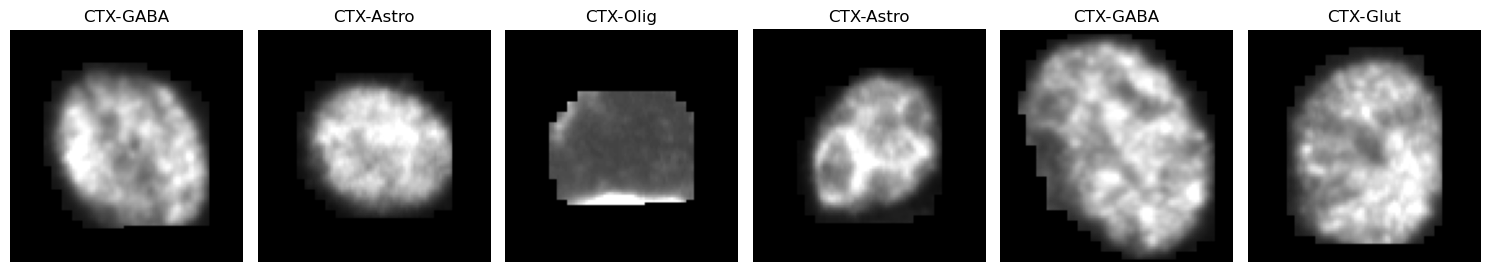

In [13]:
# visualize test batch with normalization
set_determinism(seed=0)
transforms_visualize = Compose(
    [
        LoadImaged(keys=['image'], reader="PILReader", image_only=True),
        EnsureChannelFirstd(keys=['image']),
        ScaleIntensityRangePercentilesd(
            keys=['image'], lower=1.0, upper=99.0, b_min=0.0, b_max=1.0, clip=True
        ),
        # ConcatItemsd(keys=["image"], name="image", dim=0),
    ]
)

batch_size_viz = 6
viz_ds = Dataset(train_datalist, transform=transforms_visualize)
viz_loader = DataLoader(viz_ds, batch_size=batch_size_viz, shuffle=True, num_workers=0)
batch_data = next(iter(viz_loader))

fig, axs = plt.subplots(1, batch_size_viz, figsize=(15,5))   #(10, 10 * batch_size_viz), dpi=100)
for idx in range(batch_size_viz):
    img = batch_data['image'][idx].squeeze().numpy()  # Remove channel dimension if needed
    axs[idx].imshow(img, cmap="gray")
    axs[idx].axis("off")
    label = int(batch_data['label'][idx])
    label_name = class_map_inv.get(label, f"Unknown ({label})")
    axs[idx].set_title(label_name)
fig.tight_layout()
plt.show()

In [15]:
num_classes = 4 # Replace with your actual number of classes.

# Keys for your dataset
keys = ["image"]

# Training Transforms
transforms_train = Compose(
    [
        LoadImaged(keys=keys, reader="PILReader", image_only=True),
        EnsureChannelFirstd(keys=keys),
        ScaleIntensityRangePercentilesd(
            keys=keys, lower=1.0, upper=99.0, b_min=0.0, b_max=1.0, clip=True
        ),
        ConcatItemsd(keys=keys, name="image", dim=0),
        EnsureTyped(keys=["image", "label"], track_meta=False),
        RandRotate90d(keys=["image"], prob=0.75),
        RandFlipd(keys=["image"], spatial_axis=[0, 1], prob=0.5),
        RandZoomd(keys=["image"], min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

# Validation Transforms
transforms_val = Compose(
    [
        LoadImaged(keys=keys, reader="PILReader", image_only=True),
        EnsureChannelFirstd(keys=keys),
        ScaleIntensityRangePercentilesd(
            keys=keys, lower=1.0, upper=99.0, b_min=0.0, b_max=1.0, clip=True
        ),
        ConcatItemsd(keys=keys, name="image", dim=0),
    ]
)

# Output Transformations
y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=num_classes)])

# Training Dataset and DataLoader
batch_size_train = 8
train_ds = CacheDataset(data=train_datalist, transform=transforms_train, num_workers=10)
train_loader = ThreadDataLoader(train_ds, batch_size=batch_size_train, shuffle=True)

# Validation Dataset and DataLoader
val_ds = CacheDataset(data=val_datalist, transform=transforms_val, num_workers=10)
val_loader = ThreadDataLoader(val_ds, batch_size=batch_size_train, shuffle=True)

Loading dataset: 100%|████████████████████████████████████████████████████████████| 2349/2349 [00:05<00:00, 395.00it/s]


In [17]:
# Load DenseNet169 model for training
device = "cuda:0"
model = DenseNet169(spatial_dims=2, in_channels=1, out_channels=num_classes, pretrained=True)

In [26]:
# Or load a trained model for further training

device = torch.device("cuda:0")

# Create the same model architecture as before
model = DenseNet169(
    spatial_dims=2,   # 2D images
    in_channels=1,    # single-channel images
    out_channels=4,
    pretrained=False  # Turn off ImageNet weights when resuming your own
)

# Load your trained weights
model.load_state_dict(torch.load("QUAC_model/all_types_CTX_model/H3K4me1_55epochs_model.pth", map_location=device))

model.to(device)
model.train() 

C:\Users\liany\AppData\Local\Temp\ipykernel_30036\1893600465.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("QUAC_model/all_types_CTX_

DenseNet169(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchN

In [196]:
model.to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 5e-5)   # training rate: 5e-5
max_epochs = 50   # specify number of epochs to train
val_interval = 1
auc_metric = ROCAUCMetric()

In [198]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

----------
epoch 1/50
1/686, train_loss: 1.1979
2/686, train_loss: 1.4994
3/686, train_loss: 1.7598
4/686, train_loss: 1.5240
5/686, train_loss: 1.0101
6/686, train_loss: 1.7449
7/686, train_loss: 1.5956
8/686, train_loss: 1.7474
9/686, train_loss: 1.6066
10/686, train_loss: 1.1199
11/686, train_loss: 1.9634
12/686, train_loss: 1.4111
13/686, train_loss: 1.4958
14/686, train_loss: 1.0056
15/686, train_loss: 1.5970
16/686, train_loss: 1.3118
17/686, train_loss: 1.4310
18/686, train_loss: 1.4616
19/686, train_loss: 1.2640
20/686, train_loss: 1.0623
21/686, train_loss: 1.2477
22/686, train_loss: 1.7175
23/686, train_loss: 1.4755
24/686, train_loss: 1.2742
25/686, train_loss: 1.0782
26/686, train_loss: 0.8398
27/686, train_loss: 1.1976
28/686, train_loss: 0.7933
29/686, train_loss: 0.9528
30/686, train_loss: 1.3481
31/686, train_loss: 1.0092
32/686, train_loss: 0.9839
33/686, train_loss: 1.2402
34/686, train_loss: 1.1794
35/686, train_loss: 1.0775
36/686, train_loss: 1.2803
37/686, train_l

In [199]:
# evaluate the trained classification model

batch_size_test = 32
test_ds = Dataset(val_datalist, transform=transforms_val)
test_loader = DataLoader(test_ds, batch_size=batch_size_test, shuffle=True, num_workers=4)

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data["image"].to(device),
            test_data["label"].to(device),
        )
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

    CTX-Glut     0.5985    0.6639    0.6295       595
   CTX-Astro     0.8243    0.7949    0.8093       590
    CTX-Olig     0.9808    0.9740    0.9774       576
    CTX-GABA     0.6448    0.6010    0.6221       589

    accuracy                         0.7570      2350
   macro avg     0.7621    0.7584    0.7596      2350
weighted avg     0.7605    0.7570    0.7581      2350



In [201]:
# save trained model
torch.save(model.state_dict(), "QUAC_model/all_types_CTX_model/H3K4me1_model.pth")

In [202]:
# Convert model to torch-script for QuAC
model_script = torch.jit.script(model)
model_script.save("QUAC_model/all_types_CTX_model/H3K4me1_jit.pt")